# Load libraries 

In [1]:
import pandas as pd
import numpy as np
import os
import re


# figures
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes = True)

%matplotlib inline

# Paths 

In [2]:
analysispath = os.getcwd()
datapath = analysispath + '/../data/'

# Load data 

In [3]:
data = pd.read_csv(datapath + 'holistic_face_abilities.csv')
correct_data = pd.read_csv(datapath + 'correct_answers.csv', index_col = 0)

In [4]:
# remove two first rows, not necessary
image_data = data.copy()
data = data.drop([0, 1])
data.reset_index(inplace=True, drop=True)
data.head()

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Q197_Click Count,Q198,Q199_First Click,Q199_Last Click,Q199_Page Submit,Q199_Click Count,SC0,SC1,SC2,mTurkCode
0,2020-03-19 23:34:59,2020-03-19 23:57:17,IP Address,68.100.126.33,100,1338,True,2020-03-19 23:57:19,R_3iEZpvzRS9vKVaM,NaN,...,1,2,3.107,3.107,5.003,1,68,14,54,8958129
1,2020-03-19 23:38:00,2020-03-19 23:57:24,IP Address,67.245.214.21,100,1164,True,2020-03-19 23:57:25,R_2DNSpGKVGs7xijD,NaN,...,1,3,2.843,3.097,3.988,2,73,11,62,3447207
2,2020-03-19 23:41:00,2020-03-20 00:01:39,IP Address,50.25.69.85,100,1238,True,2020-03-20 00:01:40,R_3OfB0uYMa3qd1La,NaN,...,1,3,3.184,3.184,4.934,1,76,8,68,8853818
3,2020-03-19 23:38:08,2020-03-20 00:13:20,IP Address,172.93.164.64,100,2112,True,2020-03-20 00:13:25,R_XXJk6PeLtUH8BDX,NaN,...,1,3,3.395,3.395,4.582,1,63,24,39,2631153
4,2020-03-19 23:35:53,2020-03-20 00:17:48,IP Address,108.30.47.212,100,2514,True,2020-03-20 00:17:49,R_2wiCC5uOFWRFiIG,NaN,...,1,3,3.634,3.634,5.301,1,65,6,59,6945018


# Parse data for holistic processing

In [5]:
nSubjects = data.shape[0] # number of subjects is number of rows in dataframe
print('Number of subjects: ' + str(nSubjects))

Number of subjects: 20


In [6]:
holistic_cols = [col for col in data.columns if '_Q255' in col]
holistic_data = data[holistic_cols].reset_index(drop=True)
image_data = image_data.loc[0, holistic_cols]

In [7]:
nTrials = holistic_data.shape[1] # number of trials is number of columns in holistic_data

In [8]:
traps = ['angelina.bmp', 'obama.bmp', 'scarlett.bmp', 'bradpitt.bmp']

In [9]:
mat_long = pd.DataFrame(columns =['SUBJECTID', 'MTURKCODE', 'TRIAL', 'IMAGE_NAME', 'IMAGE_NUMBER', 'CONDITION', 'RAW_ANSWER', 'CORRECT_ANSWER', 'ACCURACY', 'TRAP'])

In [10]:
row = 0
for trial in range(nTrials):
    
    id_trial = trial + 1
    
    column_name = holistic_cols[trial] # get the column name
    
    image_complete = image_data[column_name] # get image name for that trial
    
    tmp = re.search('https://storage.googleapis.com/holistic_face_abilities/(.*) - Which gender is the face you just saw?', image_complete)
    image_name = tmp.group(1) # this is the name of the image shown
    
        
    # get correct answer from csv file
    correct_answer = correct_data.loc[correct_data['REAL_NAME'] == image_name, 'CORRECT'].reset_index(drop=True)[0]

    # start subject loop
    
    for subject in range(nSubjects):
        
        id_sub = subject + 1
                
        raw_answer = holistic_data.loc[subject, column_name] # get only the holistic_data from that subject and that particular question
        
        
        workerID = data.loc[subject, 'mTurkCode'] # get mturk code      
        
        
        mat_long.loc[row, 'SUBJECTID'] = id_sub
        mat_long.loc[row, 'MTURKCODE'] = workerID
        mat_long.loc[row, 'TRIAL'] = id_trial
        mat_long.loc[row, 'IMAGE_NAME'] = image_name
        
        if image_name[0] == 'U':
            mat_long.loc[row, 'CONDITION'] = 'upright'
            # get the actual number of the image
            tmp_image = re.search('U(.*).bmp', image_name)
            image_number = int(tmp_image.group(1))
        elif image_name[0] == 'I':
            mat_long.loc[row, 'CONDITION'] = 'inverted'
            # get the actual number of the image
            tmp_image = re.search('I(.*).bmp', image_name)
            image_number = int(tmp_image.group(1))
        else:
            mat_long.loc[row, 'CONDITION'] = 'trap'
            image_number = 0
            
        mat_long.loc[row, 'IMAGE_NUMBER'] = image_number    
        mat_long.loc[row, 'RAW_ANSWER'] = raw_answer
        mat_long.loc[row, 'CORRECT_ANSWER'] = correct_answer
        
        if raw_answer == correct_answer:
            mat_long.loc[row, 'ACCURACY'] = 1
        else:
            mat_long.loc[row, 'ACCURACY'] = 0
            
        if image_name in traps:
            mat_long.loc[row, 'TRAP'] = 1
        else:
            mat_long.loc[row, 'TRAP'] = 0
                
            
        row = row + 1

In [11]:
mat_wide = pd.DataFrame(columns =['SUBJECTID', 'MTURKCODE', 'TRIAL', 'IMAGE_NAME', 'IMAGE_NUMBER', 'UPRIGHT', 'INVERTED', 'RAW_ANSWER', 'CORRECT_ANSWER', 'TRAP'])



In [12]:
# row = 0
# for trial in range(nTrials):
    
#     id_trial = trial + 1
    
#     column_name = holistic_cols[trial] # get the column name
    
#     image_complete = image_data[column_name] # get image name for that trial
    
#     tmp = re.search('https://storage.googleapis.com/holistic_face_abilities/(.*) - Which gender is the face you just saw?', image_complete)
#     image_name = tmp.group(1) # this is the name of the image shown
    
        
#     # get correct answer from csv file
#     correct_answer = correct_data.loc[correct_data['REAL_NAME'] == image_name, 'CORRECT'].reset_index(drop=True)[0]

#     # start subject loop
    
#     for subject in range(nSubjects):
        
#         id_sub = subject + 1
                
#         raw_answer = holistic_data.loc[subject, column_name] # get only the holistic_data from that subject and that particular question
        
        
#         workerID = data.loc[subject, 'mTurkCode'] # get mturk code      
        
        
#         mat_wide.loc[row, 'SUBJECTID'] = id_sub
#         mat_wide.loc[row, 'MTURKCODE'] = workerID
#         mat_wide.loc[row, 'TRIAL'] = id_trial
#         mat_wide.loc[row, 'IMAGE_NAME'] = image_name
        
            
#         mat_wide.loc[row, 'IMAGE_NUMBER'] = image_number    
#         mat_wide.loc[row, 'RAW_ANSWER'] = raw_answer
#         mat_wide.loc[row, 'CORRECT_ANSWER'] = correct_answer
        
#         if raw_answer == correct_answer:
#             accuracy = 1
#         else:
#             accuracy = 0
            
#         if image_name in traps:
#             accuracy = 1
#         else:
#             accuracy = 0
                
#         if image_name[0] == 'U':
#             mat_wide.loc[row, 'UPRIGHT'] = accuracy
#             # get the actual number of the image
#             tmp_image = re.search('U(.*).bmp', image_name)
#             image_number = int(tmp_image.group(1))
#         elif image_name[0] == 'I':
#             mat_wide.loc[row, 'INVERTED'] = accuracy
#             # get the actual number of the image
#             tmp_image = re.search('I(.*).bmp', image_name)
#             image_number = int(tmp_image.group(1))

                
                
                
#         row = row + 1

#  Check traps 

In [13]:
trap_data = mat_long[mat_long['TRAP'] == 1]

In [14]:
for subject in trap_data.SUBJECTID.unique():
    
    mean = np.mean(trap_data.loc[trap_data['SUBJECTID'] == subject, 'ACCURACY'])*100
    print('Subject ' + str(subject) + ': ' + str(mean) + '%')

Subject 1: 100.0%
Subject 2: 100.0%
Subject 3: 100.0%
Subject 4: 100.0%
Subject 5: 100.0%
Subject 6: 100.0%
Subject 7: 100.0%
Subject 8: 100.0%
Subject 9: 100.0%
Subject 10: 100.0%
Subject 11: 100.0%
Subject 12: 100.0%
Subject 13: 100.0%
Subject 14: 100.0%
Subject 15: 75.0%
Subject 16: 100.0%
Subject 17: 100.0%
Subject 18: 100.0%
Subject 19: 75.0%
Subject 20: 100.0%


# Holistic index per subject 

In [15]:
# index out traps
mat_cleaned = mat_long[mat_long['CONDITION'] != 'trap']

In [16]:
organized_data = mat_cleaned.groupby(['SUBJECTID', 'MTURKCODE', 'IMAGE_NAME', 'CONDITION'], as_index=False)

In [17]:
long_before = organized_data.aggregate(np.sum)
long_before

,SUBJECTID,MTURKCODE,IMAGE_NAME,CONDITION,TRIAL,IMAGE_NUMBER,RAW_ANSWER,CORRECT_ANSWER,ACCURACY,TRAP
0,1,8958129,I0006.bmp,inverted,1,6,Female,Female,1,0
1,1,8958129,I0014.bmp,inverted,2,14,Female,Male,0,0
2,1,8958129,I0020.bmp,inverted,3,20,Female,Male,0,0
3,1,8958129,I0061.bmp,inverted,4,61,Female,Female,1,0
4,1,8958129,I0076.bmp,inverted,5,76,Female,Female,1,0
...,...,...,...,...,...,...,...,...,...,...
1595,20,7456000,U0374.bmp,upright,76,374,Male,Female,0,0
1596,20,7456000,U0377.bmp,upright,77,377,Female,Female,1,0
1597,20,7456000,U0395.bmp,upright,78,395,Female,Male,0,0
1598,20,7456000,U0501.bmp,upright,79,501,Female,Female,1,0


In [18]:
long_after = long_before.pivot_table(index=['SUBJECTID', 'MTURKCODE', 'IMAGE_NUMBER'], columns='CONDITION', values='ACCURACY').reset_index()
long_after

CONDITION,SUBJECTID,MTURKCODE,IMAGE_NUMBER,inverted,upright
0,1,8958129,6,1.0,1.0
1,1,8958129,14,0.0,1.0
2,1,8958129,20,0.0,1.0
3,1,8958129,61,1.0,1.0
4,1,8958129,76,1.0,1.0
...,...,...,...,...,...
815,20,7456000,374,1.0,0.0
816,20,7456000,377,0.0,1.0
817,20,7456000,395,0.0,0.0
818,20,7456000,501,1.0,1.0


Now the data is organized so we can calculate the holistic index per image  

In [19]:
long_after['HOLISTIC'] = long_after['upright'] - long_after['inverted']

In [20]:
long_after

CONDITION,SUBJECTID,MTURKCODE,IMAGE_NUMBER,inverted,upright,HOLISTIC
0,1,8958129,6,1.0,1.0,0.0
1,1,8958129,14,0.0,1.0,1.0
2,1,8958129,20,0.0,1.0,1.0
3,1,8958129,61,1.0,1.0,0.0
4,1,8958129,76,1.0,1.0,0.0
...,...,...,...,...,...,...
815,20,7456000,374,1.0,0.0,-1.0
816,20,7456000,377,0.0,1.0,1.0
817,20,7456000,395,0.0,0.0,0.0
818,20,7456000,501,1.0,1.0,0.0


Now calculate holistic index per subject across images

In [21]:
subject_holistic_index = pd.DataFrame(columns = ['SUBJECTID', 'MTURKCODE', 'UPRIGHT', 'INVERTED', 'HOLISTIC_INDEX'])
row = 0
for subject in long_after.SUBJECTID.unique():
    sub_data = long_after[long_after['SUBJECTID'] == subject]
    
    subject_holistic_index.loc[row, 'SUBJECTID'] = subject
    subject_holistic_index.loc[row, 'MTURKCODE'] = int(sub_data.MTURKCODE.unique())
    subject_holistic_index.loc[row, 'UPRIGHT'] = np.mean(sub_data['upright'])
    subject_holistic_index.loc[row, 'INVERTED'] = np.mean(sub_data['inverted'])
    subject_holistic_index.loc[row, 'HOLISTIC_INDEX'] = np.mean(sub_data['HOLISTIC'])
    
    row = row + 1

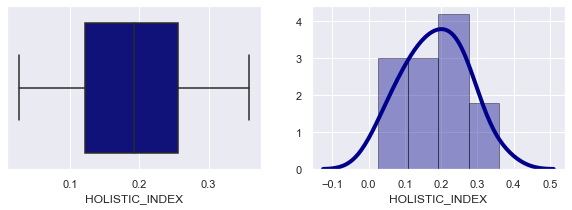

In [22]:
plt.figure(figsize=(10,3))
plt.subplot(121)
ax = sns.boxplot(x=subject_holistic_index["HOLISTIC_INDEX"], color = 'darkblue')
plt.subplot(122)

sns.distplot(subject_holistic_index['HOLISTIC_INDEX'], hist=True, kde=True, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

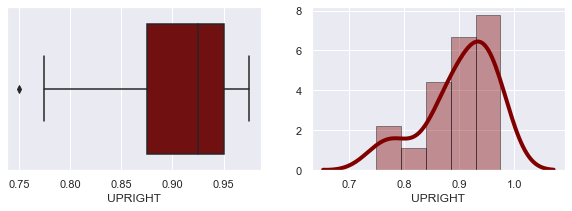

In [23]:
plt.figure(figsize=(10,3))
plt.subplot(121)
ax = sns.boxplot(x=subject_holistic_index["UPRIGHT"], color = 'maroon')

plt.subplot(122)
sns.distplot(subject_holistic_index['UPRIGHT'], hist=True, kde=True, color = 'maroon', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

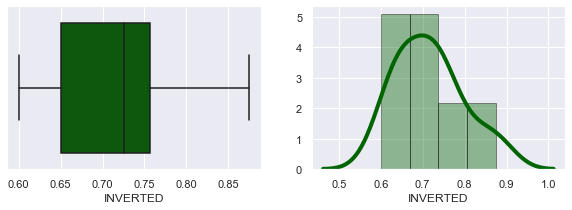

In [24]:
plt.figure(figsize=(10,3))
plt.subplot(121)
ax = sns.boxplot(x=subject_holistic_index["INVERTED"], color = 'darkgreen')

plt.subplot(122)
sns.distplot(subject_holistic_index['INVERTED'], hist=True, kde=True, color = 'darkgreen', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

# Save data 

In [25]:
subject_holistic_index.to_csv('1_processed_holistic_index.csv')